# GAN Basic
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks

In [2]:
import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
import torchvision.utils as v_utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

In [3]:
# 하이퍼 파라미터
epoch = 50
batch_size = 512
learning_rate = 0.0002
num_gpus = 1
z_size = 50
middle_size = 200

In [4]:
# 데이터 셋팅
mnist_train = dsets.MNIST('./', train=True, transform=transforms.ToTensor(), download=True)

# 데이터로더
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 39.0MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.27MB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.7MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.26MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
# Generator

class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.layer1 = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(z_size, middle_size)),
        ('bn1', nn.BatchNorm1d(middle_size)),
        ('act1', nn.ReLU())
    ]))
    self.layer2 = nn.Sequential(OrderedDict([
        ('fc2', nn.Linear(middle_size, 784)),
        ('bn2', nn.BatchNorm1d(784)),
        ('tanh', nn.Tanh())
    ]))

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(batch_size // num_gpus, 1, 28, 28)

    return out

In [6]:
# Discriminator
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.layer1 = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(784, middle_size)),
        ('bn1', nn.BatchNorm1d(middle_size)),
        ('act1', nn.LeakyReLU())
    ]))
    self.layer2 = nn.Sequential(OrderedDict([
        ('fc2', nn.Linear(middle_size, 1)),
        ('bn2', nn.BatchNorm1d(1)),
        ('act2', nn.Sigmoid())
    ]))

  def forward(self, x):
    out = x.view(batch_size // num_gpus, -1)
    out = self.layer1(out)
    out = self.layer2(out)

    return out

In [16]:
# Put instances on Multi-gpu

# generator = nn.DataParallel(Generator()).cuda
# discriminator = nn.DataParallel(Discriminator()).cuda

generator = Generator()
discriminator = Discriminator()


In [17]:
# layer 확인

gen_params = generator.state_dict().keys()
dis_params = discriminator.state_dict().keys()

for i in gen_params:
  print(i)

layer1.fc1.weight
layer1.fc1.bias
layer1.bn1.weight
layer1.bn1.bias
layer1.bn1.running_mean
layer1.bn1.running_var
layer1.bn1.num_batches_tracked
layer2.fc2.weight
layer2.fc2.bias
layer2.bn2.weight
layer2.bn2.bias
layer2.bn2.running_mean
layer2.bn2.running_var
layer2.bn2.num_batches_tracked


In [27]:
# 손실 함수 및 옵티마이저 설정
loss_func = nn.MSELoss()
gen_optim = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
dis_optim = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

ones_label = torch.ones(batch_size, 1)
zeros_label = torch.zeros(batch_size, 1)

In [28]:
# 모델 학습

for i in range(epoch):
  for j, [image, label] in enumerate(train_loader):
    # discriminator
    dis_optim.zero_grad()

    z = init.normal_(torch.Tensor(batch_size, z_size), mean=0, std=0.1)
    gen_fake = generator(z)
    dis_fake = discriminator(gen_fake)

    dis_real = discriminator(image)
    dis_loss = torch.sum(loss_func(dis_fake, zeros_label)) + torch.sum(loss_func(dis_real, ones_label))
    dis_loss.backward(retain_graph=True) # backward 연산 후에도 그래프를 유지
    dis_optim.step()

    # generator

    gen_optim.zero_grad()

    z = init.normal_(torch.Tensor(batch_size, z_size))
    gen_fake = generator(z)
    dis_fake = discriminator(gen_fake)

    gen_loss = torch.sum(loss_func(dis_fake, ones_label))
    gen_loss.backward()

    gen_optim.step()

    if j % 100 == 0:
      print(gen_loss, dis_loss)

      print('{}th iteration gen_loss: {} dis_loss: {}'.format(i, gen_loss.data, dis_loss.data))


tensor(0.2900, grad_fn=<SumBackward0>) tensor(0.5858, grad_fn=<AddBackward0>)
0th iteration gen_loss: 0.2899933457374573 dis_loss: 0.5858433246612549
tensor(0.2966, grad_fn=<SumBackward0>) tensor(0.5169, grad_fn=<AddBackward0>)
0th iteration gen_loss: 0.2965840995311737 dis_loss: 0.5168861150741577
tensor(0.2949, grad_fn=<SumBackward0>) tensor(0.5166, grad_fn=<AddBackward0>)
1th iteration gen_loss: 0.2949068248271942 dis_loss: 0.5166444182395935
tensor(0.2911, grad_fn=<SumBackward0>) tensor(0.5055, grad_fn=<AddBackward0>)
1th iteration gen_loss: 0.29105237126350403 dis_loss: 0.5054516792297363
tensor(0.2885, grad_fn=<SumBackward0>) tensor(0.5007, grad_fn=<AddBackward0>)
2th iteration gen_loss: 0.28848159313201904 dis_loss: 0.500660240650177
tensor(0.2874, grad_fn=<SumBackward0>) tensor(0.4922, grad_fn=<AddBackward0>)
2th iteration gen_loss: 0.2874404489994049 dis_loss: 0.49221158027648926
tensor(0.2874, grad_fn=<SumBackward0>) tensor(0.4925, grad_fn=<AddBackward0>)
3th iteration gen_lo

# DCGAN


In [1]:
import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
import torchvision.utils as v_utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# 하이퍼파라미터 설정
epoch = 50
batch_size = 512
learning_rate = 0.0002
num_gpus = 1

In [12]:
# 데이터
mnist_train = dsets.MNIST('./', train=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                          ]),
                          download=True)

train_loader = utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)

In [4]:
# Generator
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Linear(100, 7*7*256),
        nn.BatchNorm1d(7*7*256),
        nn.ReLU(),
    )
    self.layer2 = nn.Sequential(OrderedDict([
        ('conv1', nn.ConvTranspose2d(256, 128, 3, 2, 1, 1)),
        ('bn1', nn.BatchNorm2d(128)),
        ('relu1', nn.LeakyReLU()),
        ('conv2', nn.ConvTranspose2d(128, 64, 3, 1, 1)),
        ('bn2', nn.BatchNorm2d(64)),
        ('relu', nn.LeakyReLU())
    ]))
    self.layer3 = nn.Sequential(OrderedDict([
        ('conv3', nn.ConvTranspose2d(64, 16, 3, 1, 1)),
        ('bn3', nn.BatchNorm2d(16)),
        ('relu3', nn.LeakyReLU()),
        ('conv4', nn.ConvTranspose2d(16, 1, 3, 2, 1, 1)),
        ('tanh', nn.Tanh())
    ]))

  def forward(self, x):
    out = self.layer1(x)
    out = out.view(batch_size // num_gpus, 256, 7, 7)
    out = self.layer2(out)
    out = self.layer3(out)
    return out

In [5]:
# DisCriminator
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.layer1 = nn.Sequential(OrderedDict([
        ('conv1', nn.Conv2d(1, 8, 3, padding=1)), # batch x 16 x 28 x 28
        ('bn1', nn.BatchNorm2d(8)),
        ('relu1', nn.LeakyReLU()),
        ('conv2', nn.Conv2d(8, 16, 3, padding=1)),
        ('bn2', nn.BatchNorm2d(16)),
        ('relu', nn.LeakyReLU()),
        ('max1', nn.MaxPool2d(2, 2)) # batch x 16 x 14 x 14
    ]))
    self.layer2 = nn.Sequential(OrderedDict([
        ('conv3', nn.Conv2d(16, 32, 3, padding=1)),
        ('bn3', nn.BatchNorm2d(32)),
        ('relu3', nn.LeakyReLU()),
        ('max2', nn.MaxPool2d(2, 2)),
        ('conv4', nn.Conv2d(32, 64, 3, padding=1)),
        ('bn4', nn.BatchNorm2d(64)),
        ('relu4', nn.LeakyReLU())
    ]))
    self.fc = nn.Sequential(
        nn.Linear(64*7*7, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(batch_size//num_gpus, -1)
    out = self.fc(out)
    return out

In [6]:
# 모델
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [7]:
# layer 확인
gen_params = generator.state_dict().keys()
dis_params = discriminator.state_dict().keys()

for i in gen_params:
  print(i)

layer1.0.weight
layer1.0.bias
layer1.1.weight
layer1.1.bias
layer1.1.running_mean
layer1.1.running_var
layer1.1.num_batches_tracked
layer2.conv1.weight
layer2.conv1.bias
layer2.bn1.weight
layer2.bn1.bias
layer2.bn1.running_mean
layer2.bn1.running_var
layer2.bn1.num_batches_tracked
layer2.conv2.weight
layer2.conv2.bias
layer2.bn2.weight
layer2.bn2.bias
layer2.bn2.running_mean
layer2.bn2.running_var
layer2.bn2.num_batches_tracked
layer3.conv3.weight
layer3.conv3.bias
layer3.bn3.weight
layer3.bn3.bias
layer3.bn3.running_mean
layer3.bn3.running_var
layer3.bn3.num_batches_tracked
layer3.conv4.weight
layer3.conv4.bias


In [14]:
# 손실 함수 및 옵티마이저
loss_func = nn.MSELoss().to(device)
gen_optim = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
dis_optim = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

ones_label = torch.ones(batch_size, 1).to(device)
zeros_label = torch.zeros(batch_size, 1).to(device)

def image_check(gen_fake):
  img = gen_fake.data.numpy()
  for i in range(10):
    plt.imshow(img[i][0], cmap='gray')
    plt.show()

tensor(0.2564, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4240, device='cuda:0', grad_fn=<AddBackward0>)
0th iteration gen_loss: 0.25637519359588623 dis_loss: 0.4239839017391205
tensor(0.8323, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0236, device='cuda:0', grad_fn=<AddBackward0>)
0th iteration gen_loss: 0.8322536945343018 dis_loss: 0.023608949035406113
tensor(0.8835, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0136, device='cuda:0', grad_fn=<AddBackward0>)
0th iteration gen_loss: 0.8835330009460449 dis_loss: 0.013556914404034615


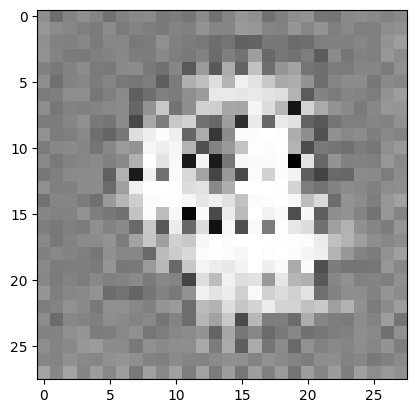

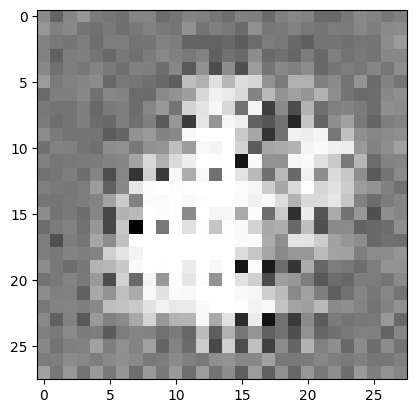

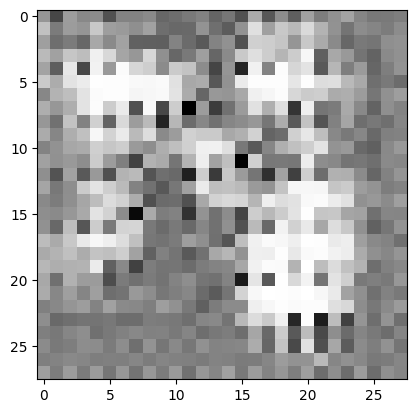

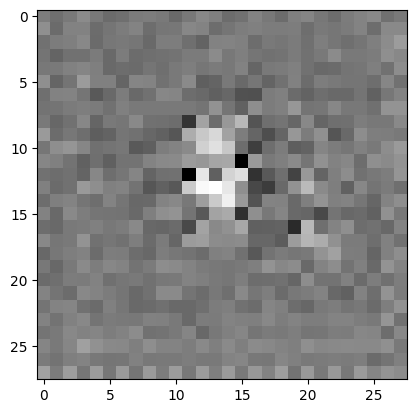

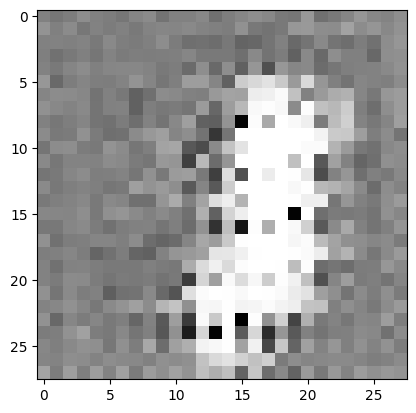

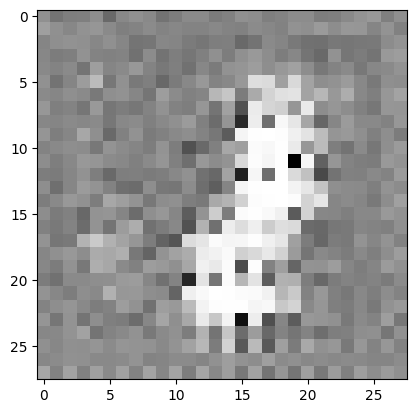

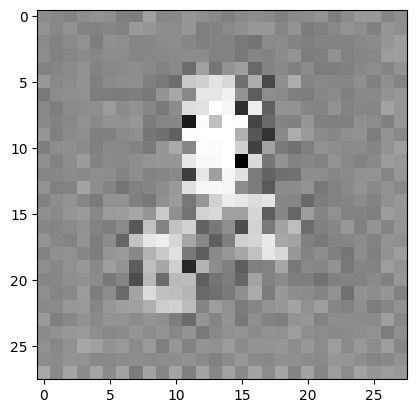

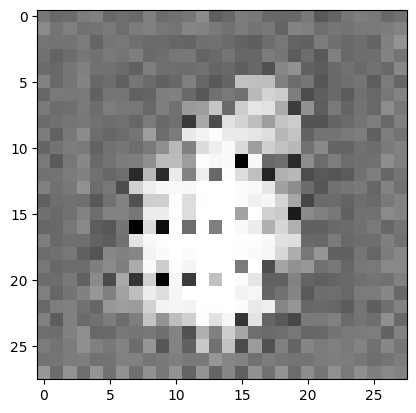

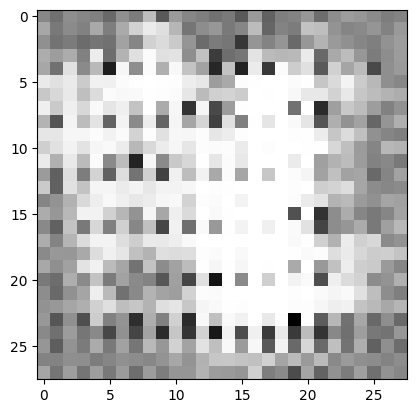

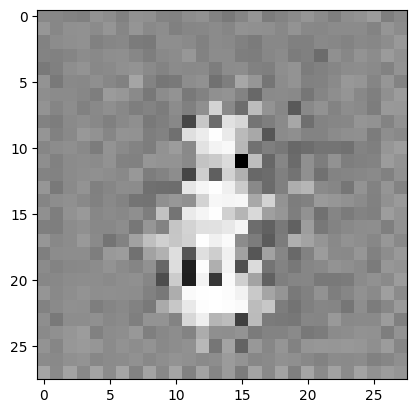

tensor(0.8915, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0135, device='cuda:0', grad_fn=<AddBackward0>)
1th iteration gen_loss: 0.8914770483970642 dis_loss: 0.013460397720336914
tensor(0.8790, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0157, device='cuda:0', grad_fn=<AddBackward0>)
1th iteration gen_loss: 0.8790472745895386 dis_loss: 0.015669070184230804
tensor(0.8724, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0249, device='cuda:0', grad_fn=<AddBackward0>)
1th iteration gen_loss: 0.8723928928375244 dis_loss: 0.02493615821003914


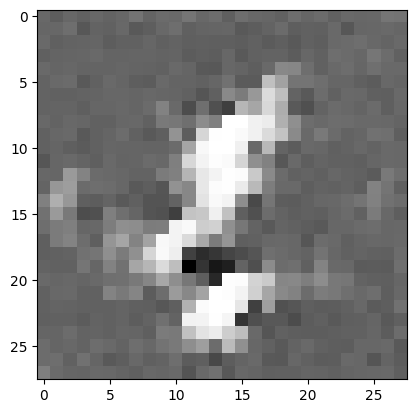

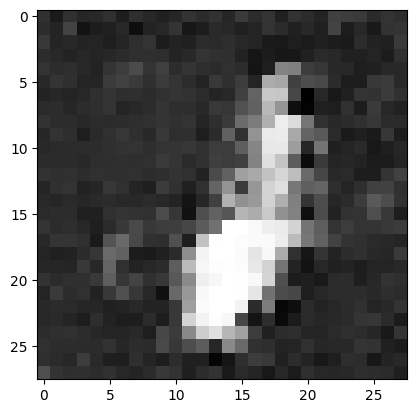

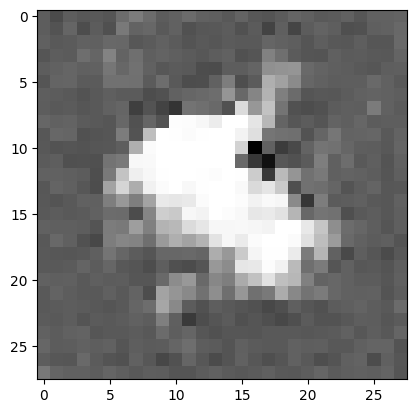

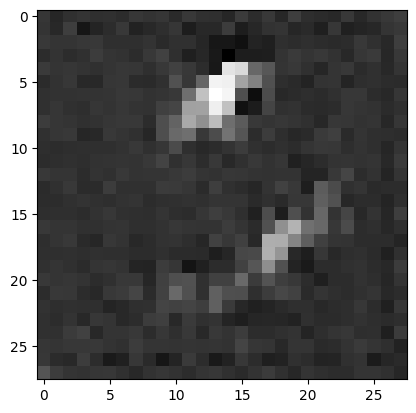

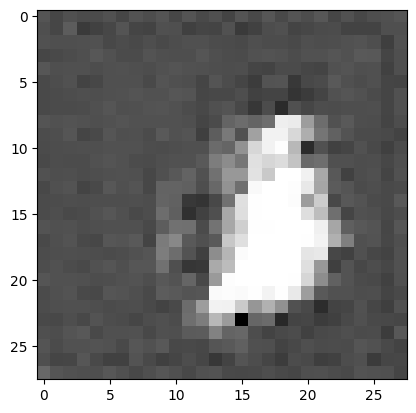

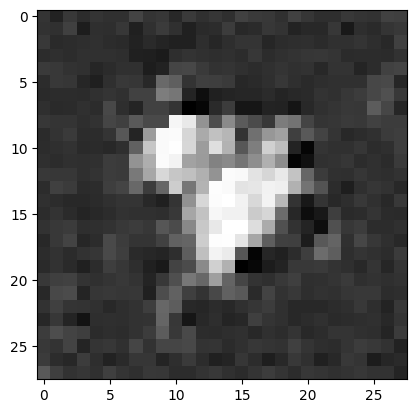

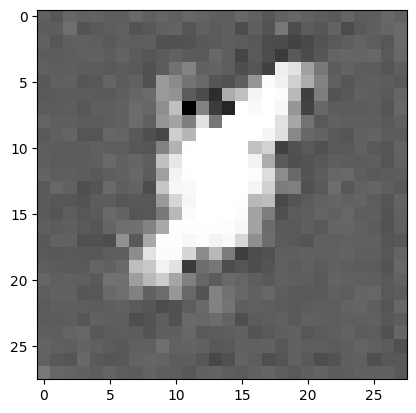

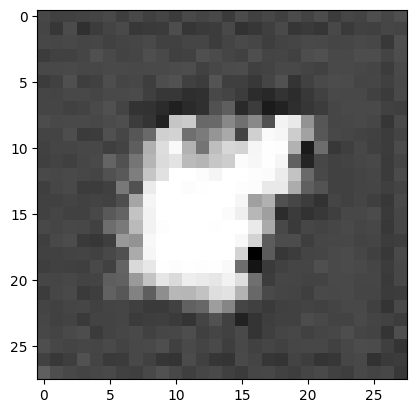

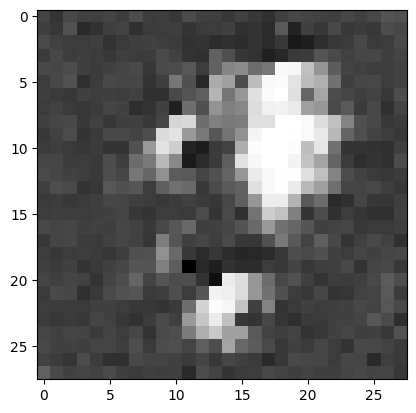

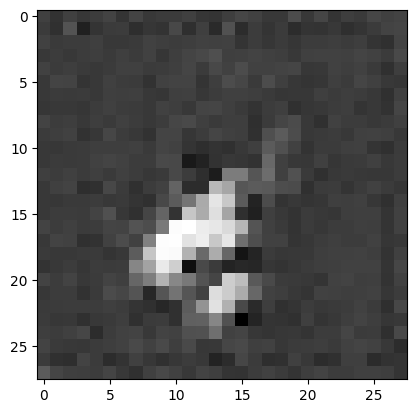

tensor(0.8943, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0121, device='cuda:0', grad_fn=<AddBackward0>)
2th iteration gen_loss: 0.8943231105804443 dis_loss: 0.01208686176687479
tensor(0.9162, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0202, device='cuda:0', grad_fn=<AddBackward0>)
2th iteration gen_loss: 0.9161825180053711 dis_loss: 0.020219499245285988
tensor(0.9056, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0035, device='cuda:0', grad_fn=<AddBackward0>)
2th iteration gen_loss: 0.9055938720703125 dis_loss: 0.003461900632828474


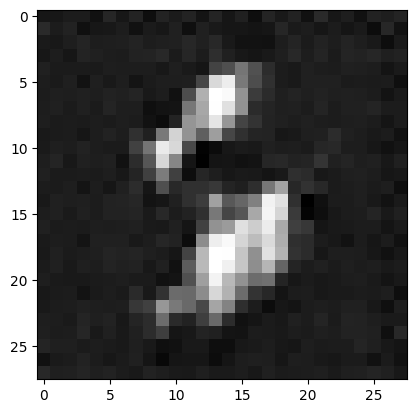

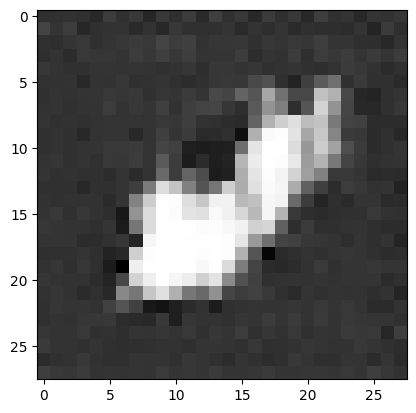

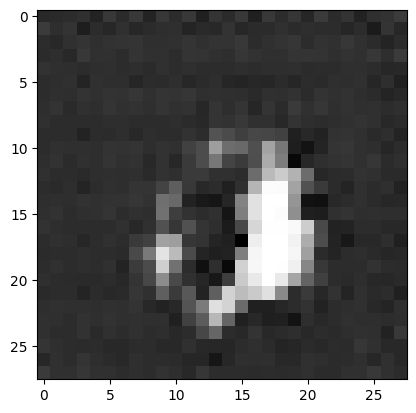

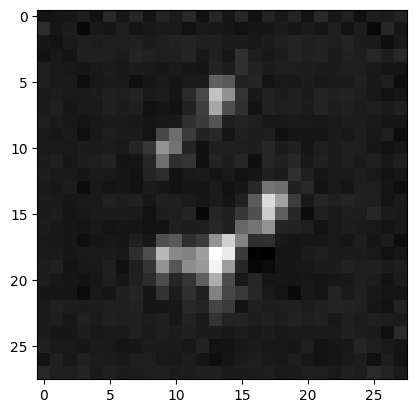

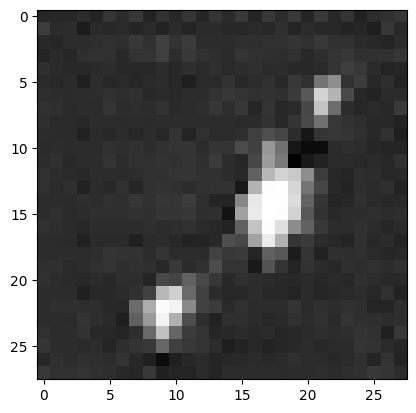

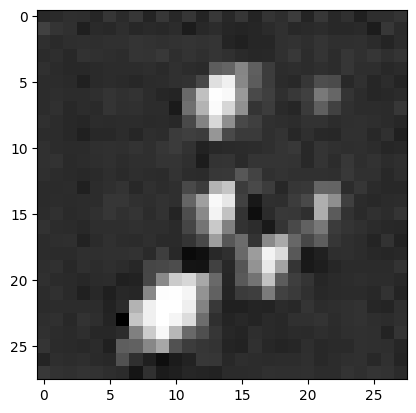

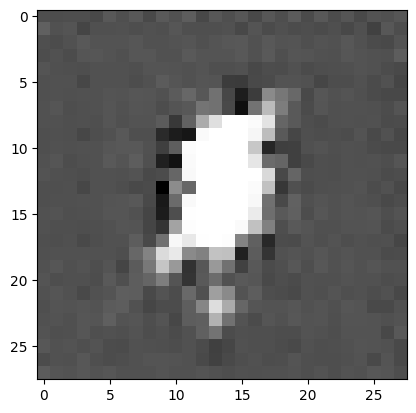

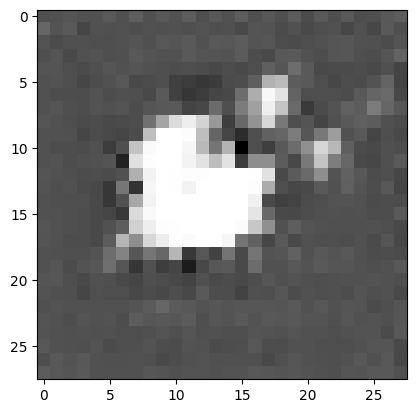

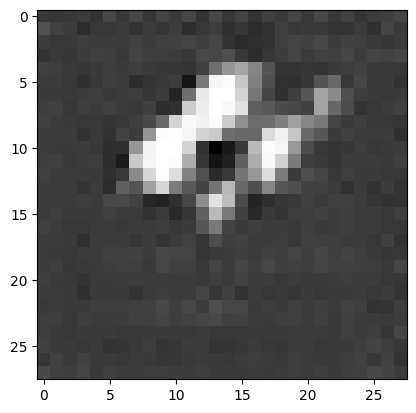

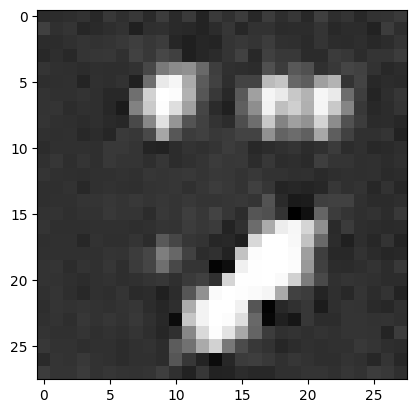

tensor(0.9180, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0031, device='cuda:0', grad_fn=<AddBackward0>)
3th iteration gen_loss: 0.918043851852417 dis_loss: 0.003064884804189205
tensor(0.9465, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0079, device='cuda:0', grad_fn=<AddBackward0>)
3th iteration gen_loss: 0.9464796781539917 dis_loss: 0.007924310863018036


KeyboardInterrupt: 

In [17]:
# 모델 학습

for i in range(epoch):
  for j, [image, label] in enumerate(train_loader):
    image = image.to(device)
    # generator
    gen_optim.zero_grad()

    z = init.normal_(torch.Tensor(batch_size, 100), mean=0, std=0.1).to(device)
    gen_fake = generator(z)
    dis_fake = discriminator(gen_fake)

    gen_loss = torch.sum(loss_func(dis_fake, ones_label))
    gen_loss.backward(retain_graph=True)
    gen_optim.step()

    # discriminator
    dis_optim.zero_grad()

    z = init.normal_(torch.Tensor(batch_size, 100), mean=0, std=0.1).to(device)
    gen_fake = generator(z)
    dis_fake = discriminator(gen_fake)

    dis_real = discriminator(image)
    dis_loss = torch.sum(loss_func(dis_fake, zeros_label)) + torch.sum(loss_func(dis_real, ones_label))
    dis_loss.backward()
    dis_optim.step()

    if j % 50 == 0:
      print(gen_loss, dis_loss)
      # torch.save([generator, discriminator], './model/dcgan.pkl')

      print('{}th iteration gen_loss: {} dis_loss: {}'.format(i, gen_loss.data, dis_loss.data))
      v_utils.save_image(gen_fake.data[0:25], './result/gen_{}_{}.png'.format(i, j), nrow=5)

  image_check(gen_fake.cpu())